In [ ]:


# """
# Imports necessary packages and creates a function (fred_csv()) which scrapes data from the webpage as a csv file and adds it to a Data Frame

# | Indicator                 | FRED Series ID |
# | ------------------------- | -------------- |
# | Unemployment Rate         | `UNRATE`       |
# | Job Openings Rate         | `JTSJOR`       |
# | Quits Rate                | `JTSQUR`       |
# | Layoffs & Discharges Rate | `JTSLDR`       |
# | Initial Claims (weekly)   | `ICSA`         
# | Labor Force Participation | `CIVPART`      |
# | Part time for econreasons |`PART_TIME_ECON`|

# some private company indicators (LinkedIn)
# google trends alt data (new jobs, work near me, etc)


# """
import pandas as pd
import numpy as np
import requests
import os

FRED_API_KEY = os.getenv("FRED_API_KEY")

def fred(series_id, start, end):
    url = "https://api.stlouisfed.org/fred/series/observations"
    params = {
        "series_id": series_id,
        "api_key": FRED_API_KEY,
        "file_type": "json",
        "observation_start": start,
        "observation_end": end,
    }

    r = requests.get(url, params=params, timeout=30)
    r.raise_for_status()

    obs = r.json()["observations"]

    s = pd.Series(
        [o["value"] for o in obs],
        index=pd.to_datetime([o["date"] for o in obs]),
        name=series_id
    )

    s = pd.to_numeric(s.replace(".", np.nan), errors="coerce")
    return s


def fred_bundle(series_ids, start, end, weekly_to_monthly=None):
    weekly_to_monthly = set(weekly_to_monthly or [])
    series_list = []

    for sid in series_ids:
        s = fred(sid, start, end)

        # Convert weekly to monthly if needed
        if sid in weekly_to_monthly:
            s = s.resample("ME").mean()
        else:
            s = s.resample("ME").last()

        series_list.append(s)

    df = pd.concat(series_list, axis=1).dropna()
    return df


# -----------------------------------
# Pull your labor market data
# -----------------------------------

start = "2007-01-01"
end   = "2026-12-31"   # safe to set ahead

series_ids = ["UNRATE", "JTSJOR", "JTSQUR", "JTSLDR", "ICSA", "CIVPART", "LNS12032196"]

data = fred_bundle(series_ids, start, end, weekly_to_monthly=["ICSA"])

data = data.rename(columns={
    "LNS12032196": "PART_TIME_ECON"
})

print("Latest month with all series:", data.index.max())
data.tail()


Latest month with all series: 2025-12-31 00:00:00


,UNRATE,JTSJOR,JTSQUR,JTSLDR,ICSA,CIVPART,PART_TIME_ECON
2025-07-31,4.3,4.3,2.0,1.1,221250.0,62.2,1289.0
2025-08-31,4.3,4.3,1.9,1.1,230000.0,62.3,1332.0
2025-09-30,4.4,4.6,2.0,1.1,234750.0,62.5,1200.0
2025-11-30,4.5,4.2,2.0,1.1,217600.0,62.5,1650.0
2025-12-31,4.4,3.9,2.0,1.1,219000.0,62.4,1514.0


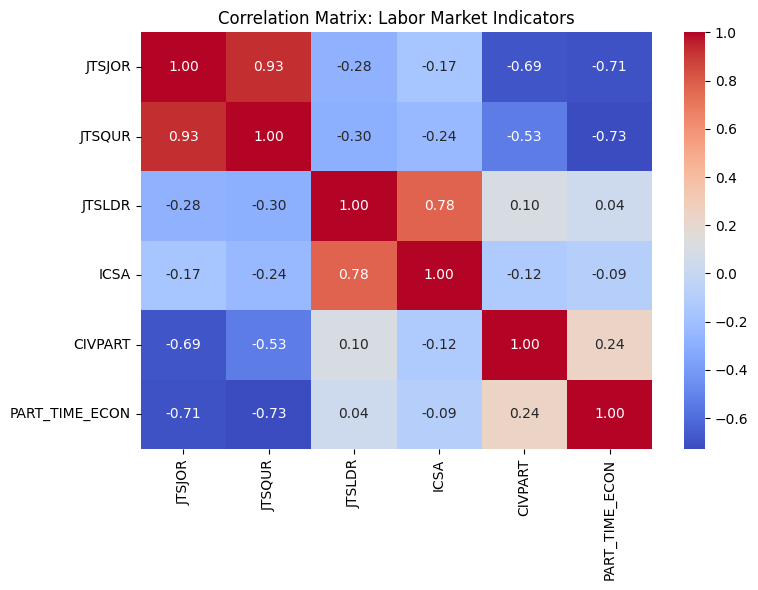

JTSJOR: -0.058
JTSQUR: 0.018
JTSLDR: 0.146
ICSA: -0.241
CIVPART: 0.244
PART_TIME_ECON: -0.034


In [91]:
import matplotlib.pyplot as plt
import seaborn as sns

# 3-month forward change
data["UNRATE_3M_CHANGE"] = data["UNRATE"].shift(-3) - data["UNRATE"]

data = data.dropna()

indicators = data.drop(columns=["UNRATE", "UNRATE_3M_CHANGE"])
corr_matrix = indicators.corr()
corr_matrix



plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix: Labor Market Indicators")
plt.tight_layout()
plt.show()

predictors = ["JTSJOR", "JTSQUR", "JTSLDR", "ICSA", "CIVPART", "PART_TIME_ECON"]

for var in predictors:
    corr = data[var].corr(data["UNRATE_3M_CHANGE"])
    print(f"{var}: {corr:.3f}")

pre = data.loc[:'2019-12-31']
post = data.loc['2020-01-01':]


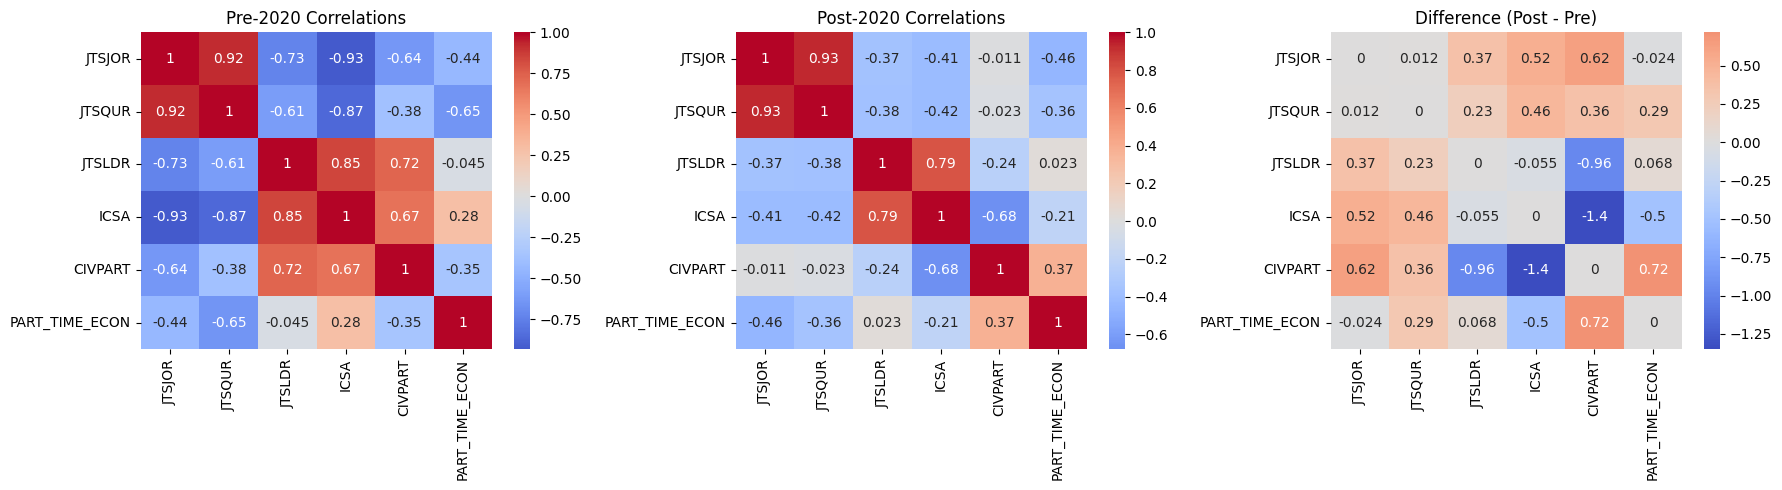

In [92]:


# Use indicators only (exclude unemployment change)
cols = ["JTSJOR", "JTSQUR", "JTSLDR", "ICSA", "CIVPART", "PART_TIME_ECON"]

pre_corr = pre[cols].corr()
post_corr = post[cols].corr()

corr_diff = post_corr - pre_corr

import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 3, figsize=(18,5))

sns.heatmap(pre_corr, annot=True, cmap="coolwarm", center=0, ax=axes[0])
axes[0].set_title("Pre-2020 Correlations")

sns.heatmap(post_corr, annot=True, cmap="coolwarm", center=0, ax=axes[1])
axes[1].set_title("Post-2020 Correlations")

sns.heatmap(corr_diff, annot=True, cmap="coolwarm", center=0, ax=axes[2])
axes[2].set_title("Difference (Post - Pre)")

plt.tight_layout()
plt.show()


In [93]:
data["UNRATE_3M_PCT_CHANGE"] = (
    (data["UNRATE"].shift(-3) - data["UNRATE"]) 
    / data["UNRATE"]
)
data = data.dropna()

In [94]:
#Below is running a regression with indicators pre/post 2020

from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm

scaler = StandardScaler()

data_scaled = data.copy()
data_scaled[predictors] = scaler.fit_transform(data[predictors])

pre = data_scaled.loc[:'2019-12-31']
post = data_scaled.loc['2020-04-01':]


In [95]:

X_pre = sm.add_constant(pre[predictors])
y_pre = pre["UNRATE_3M_PCT_CHANGE"]

model_pre = sm.OLS(y_pre, X_pre).fit()

print("PRE-2020 RESULTS\n")
print(model_pre.summary())


PRE-2020 RESULTS

                             OLS Regression Results                             
Dep. Variable:     UNRATE_3M_PCT_CHANGE   R-squared:                       0.530
Model:                              OLS   Adj. R-squared:                  0.511
Method:                   Least Squares   F-statistic:                     27.95
Date:                  Tue, 17 Feb 2026   Prob (F-statistic):           3.31e-22
Time:                          18:31:19   Log-Likelihood:                 274.79
No. Observations:                   156   AIC:                            -535.6
Df Residuals:                       149   BIC:                            -514.2
Df Model:                             6                                         
Covariance Type:              nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const 

In [96]:
X_post = sm.add_constant(post[predictors])
y_post = post["UNRATE_3M_PCT_CHANGE"]

model_post = sm.OLS(y_post, X_post).fit()

print("POST-2020 RESULTS\n")
print(model_post.summary())

POST-2020 RESULTS

                             OLS Regression Results                             
Dep. Variable:     UNRATE_3M_PCT_CHANGE   R-squared:                       0.824
Model:                              OLS   Adj. R-squared:                  0.805
Method:                   Least Squares   F-statistic:                     43.04
Date:                  Tue, 17 Feb 2026   Prob (F-statistic):           4.86e-19
Time:                          18:31:19   Log-Likelihood:                 108.86
No. Observations:                    62   AIC:                            -203.7
Df Residuals:                        55   BIC:                            -188.8
Df Model:                             6                                         
Covariance Type:              nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const

In [101]:
model_pre_HAC = sm.OLS(y_pre, X_pre).fit(cov_type="HAC", cov_kwds={"maxlags": 3})
model_post_HAC = sm.OLS(y_post, X_post).fit(cov_type="HAC", cov_kwds={"maxlags": 3})

print(model_pre_HAC.summary())

                             OLS Regression Results                             
Dep. Variable:     UNRATE_3M_PCT_CHANGE   R-squared:                       0.530
Model:                              OLS   Adj. R-squared:                  0.511
Method:                   Least Squares   F-statistic:                     9.857
Date:                  Tue, 17 Feb 2026   Prob (F-statistic):           3.81e-09
Time:                          18:33:57   Log-Likelihood:                 274.79
No. Observations:                   156   AIC:                            -535.6
Df Residuals:                       149   BIC:                            -514.2
Df Model:                             6                                         
Covariance Type:                    HAC                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.012

In [102]:
print(model_post_HAC.summary())

                             OLS Regression Results                             
Dep. Variable:     UNRATE_3M_PCT_CHANGE   R-squared:                       0.824
Model:                              OLS   Adj. R-squared:                  0.805
Method:                   Least Squares   F-statistic:                     487.4
Date:                  Tue, 17 Feb 2026   Prob (F-statistic):           8.52e-46
Time:                          18:33:58   Log-Likelihood:                 108.86
No. Observations:                    62   AIC:                            -203.7
Df Residuals:                        55   BIC:                            -188.8
Df Model:                             6                                         
Covariance Type:                    HAC                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.041